# MKC: Web article
https://towardsdatascience.com/using-cnns-and-rnns-for-music-genre-recognition-2435fb2ed6af

https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

In [1]:
import os

data_dir       = 'data2'
audio_data_dir = os.path.join(os.getcwd(), data_dir, "audio")

In [2]:
import numpy as np
import os
from os.path import isfile
import pathlib
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers
import time

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
C:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWarning:

### Load training and Validation arrays

In [3]:
dict_reciter_to_label =  {'AbdurrahmaanAs-Sudais': 0, 'Ajami': 1, 'Alafasy': 2, 'FaresAbbad': 3, 'Ghamadi': 4}

dict_reciters = dict_reciter_to_label

reverse_map = {v: k for k, v in dict_reciters.items()}
print(reverse_map)

{0: 'AbdurrahmaanAs-Sudais', 1: 'Ajami', 2: 'Alafasy', 3: 'FaresAbbad', 4: 'Ghamadi'}


In [4]:
npzfile = np.load(os.path.join(data_dir, 'shuffled_train_log.npz'))
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(3000, 646, 128) (3000, 5)


In [5]:
npzfile = np.load(os.path.join(data_dir, 'shuffled_valid_log.npz'))
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(1000, 646, 128) (1000, 5)


In [6]:
# MKC: TO understand why y_valiad & y_train are not coming out as (*, 8)
import pandas as pd
y_valid_pd = pd.DataFrame(y_valid)
y_valid_pd.describe()
y_valid_pd.head()


,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0


### Check by plotting a Spectogram

AbdurrahmaanAs-Sudais


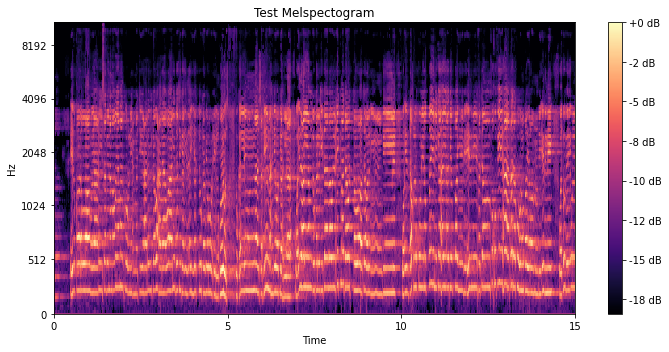

In [7]:
num = 4
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

### BiLSTM Model

In [8]:
num_classes = len(dict_reciters)
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [9]:
# MKC: Convert to BiLSTM model
from keras.layers import Bidirectional
#from keras.layers import RecurrentDropout
N_LAYERS = 3
N_LAYERS = 1 # Rev12
N_LAYERS = 0 # Rev12

FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
#MKC
#LSTM_COUNT_2 = LSTM_COUNT / 2
LSTM_COUNT_2 = 48

print("LSTM_COUNT_2 = ", LSTM_COUNT_2)
EPOCH_COUNT = 70
EPOCH_COUNT = 15
print("EPOCH_COUNT = ", EPOCH_COUNT)
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    # MKC: Iter 1: Make first layer bi-directional
    """
    ## LSTM Layer
    # MKC: Original
    #layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Bidirectional(LSTM(LSTM_COUNT, return_sequences=False))(layer)
    layer = Dropout(0.4)(layer)
Epoch 00069: val_accuracy improved from 0.53250 to 0.54250, saving model to ./models/bilstm/weights.best.h5
Epoch 70/70
6394/6394 [==============================] - 72s 11ms/step - loss: 0.9016 - accuracy: 0.7287 - val_loss: 1.8007 - val_accuracy: 0.5138

Epoch 00070: val_accuracy did not improve from 0.54250
accuracy: 0.51375 (Improved from 0.50625)
Load file: accuracy: 0.41625 (dropped from 0.44125)

    """

    # Rev12: Reducing one layer
    #layer = Bidirectional(LSTM(LSTM_COUNT, dropout=0.05, recurrent_dropout=0.35, return_sequences=True))(layer)
    #layer = Dropout(0.05)(layer)
    #layer = Recurrent_Dropout(0.35)(layer)

    layer = Bidirectional(LSTM(LSTM_COUNT_2, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))(layer)
    #layer = Dropout(0.05)(layer)
    #layer = Recurrent_Dropout(0.35)(layer)
    """
    Epoch 00069: val_accuracy did not improve from 0.51125
Epoch 70/70
6394/6394 [==============================] - 169s 26ms/step - loss: 0.9305 - accuracy: 0.7169 - val_loss: 1.7447 - val_accuracy: 0.5013

Epoch 00070: val_accuracy did not improve from 0.51125
Load file: accuracy: 0.4275 (dropped from 0.44125)
    """

    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

LSTM_COUNT_2 =  48
EPOCH_COUNT =  15


In [10]:
import pathlib

my_models_dir = os.path.join(os.getcwd(), "models")
if not pathlib.Path(my_models_dir).exists():
    print("Directory doesn't exist ...")
    audio_data_initialize(dir_name=my_models_dir)

my_models_dir = os.path.join(os.getcwd(), "models/bilstm")
if not pathlib.Path(my_models_dir).exists():
    print("Directory doesn't exist ...")
    audio_data_initialize(dir_name=my_models_dir)
    
def train_model(x_train, y_train, x_val, y_val, notrain=False):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    #input_shape = (X_train.shape[1], X_train.shape[2])
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/bilstm/weights.best.{epoch:02d}-{val_accuracy:.2f}.h5', monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')

    # MKC: Original line was:
    #           monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
    # Changed val_acc to val_accuracy to get rid of this warning:
    3#C:\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
    #'skipping.' % (self.monitor), RuntimeWarning)
    #C:\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
    #(self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    if notrain is True:
        print("No training this time!")
        return None, None
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history


In [11]:
print("Compiling ...")
junk1, junk2  = train_model(X_train, y_train, X_valid, y_valid, notrain=True)

Compiling ...
Building model...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 96)                67968     
_________________________________________________________________
dense1 (Dense)               (None, 64)                6208      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
_________________________________________________________________
output_realtime (Activation) (None, 5)                 0         
Total params: 74,501
Trainable params: 74,501
Non-trainable params: 0
_______________________

In [12]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    # MKC: Changed acc to accuracy
    #plt.plot(history.history['acc'])
    plt.plot(history.history['accuracy'])
    # MKC: Changed val_acc to val_accuracy
    #plt.plot(history.history['val_acc'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
t0 = time.time()

model, history  = train_model(X_train, y_train, X_valid, y_valid)

print("DONE in {:0.3} sec\n".format(time.time() - t0))


Building model...
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 96)                67968     
_________________________________________________________________
dense1 (Dense)               (None, 64)                6208      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
_________________________________________________________________
output_realtime (Activation) (None, 5)                 0         
Total params: 74,501
Trainable params: 74,501
Non-trainable params: 0
_____________________________________

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


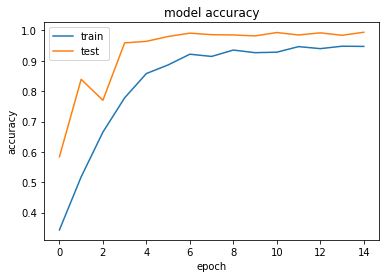

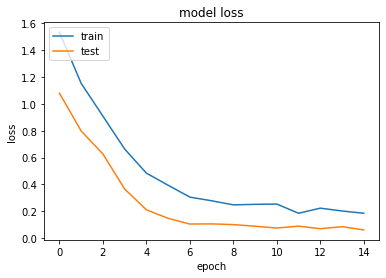

In [14]:
show_summary_stats(history)

In [15]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [i for i in range(0, len(dict_reciters))]
target_names = dict_reciters.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(1000,) (1000,)
                       precision    recall  f1-score   support

AbdurrahmaanAs-Sudais       1.00      0.98      0.99       200
                Ajami       0.99      0.99      0.99       200
              Alafasy       0.98      1.00      0.99       200
           FaresAbbad       1.00      1.00      1.00       200
              Ghamadi       1.00      1.00      1.00       200

             accuracy                           0.99      1000
            macro avg       0.99      0.99      0.99      1000
         weighted avg       0.99      0.99      0.99      1000



In [16]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.994


### Connect to Test Set

In [24]:
from keras.models import load_model

#weights_path = 'models/bilstm/weights.best.h5'
#weights_path = './models/bilstm/weights.best.06-0.89.h5'
weights_path = './models/bilstm/weights.best.15-0.99.h5'
model = load_model(weights_path)

In [25]:
npzfile = np.load(os.path.join(data_dir, 'test_arr.npz'))
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(1000, 646, 128) (1000, 5)


In [26]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

-1.0 0.0 -0.8


In [27]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000008783668917 0.0022243006867662166


In [28]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [i for i in range(0, len(dict_reciters))]
target_names = dict_reciters.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(1000,) (1000,)
                       precision    recall  f1-score   support

AbdurrahmaanAs-Sudais       0.22      0.21      0.22       200
                Ajami       0.23      0.23      0.23       200
              Alafasy       0.17      0.17      0.17       200
           FaresAbbad       0.18      0.18      0.18       200
              Ghamadi       0.23      0.23      0.23       200

             accuracy                           0.20      1000
            macro avg       0.21      0.21      0.21      1000
         weighted avg       0.21      0.20      0.21      1000



In [29]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[43 45 34 40 38]
 [34 46 45 42 33]
 [45 41 35 37 42]
 [44 35 44 36 41]
 [30 34 44 47 45]]


In [30]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.205


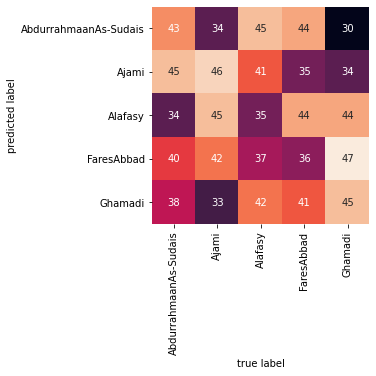

In [31]:
### 8 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_reciters.keys(),
            yticklabels=dict_reciters.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');
